# Fault detection with Unsupervised Machine Learning identifying Performance Anomalies


## Identification of the problem: 

Analogy: Performance behavior anomaly is a symptom of a disease. But multiple diseases can generate changes in performance behavior. 

Reasons: 
- System
- Architecture
- Workload
- Application( Faults, Updates, etc)

Idea: Tricorder, which can detect potential faults by identifying performance problems.

Data: Performance data are a **time series of the values** of a set of performance metrics, systematically sampled over a regular interval.

Detection process efficiency influenced by data collection:
1. **Profiling vs. Tracing**: 
    - Resource consumption behavior and dependencies and aditionally describe the dynamics of the system and predict performance. 
    - Track events may reveal the execution flow, actions performed, etc.
    - Focus on the research.
2. System Observability: Source code features would help? Not focus on the research.
3. Influence of sampling interval: 30s in intervals of 100 ms. Tradeoff between details and overhead. Not focus on the research.

Detection Strategies:
Influenced by system observability and nature of detection( Offline or online mode).
1. **Observational Detection**: Analyzing log files.
2. Signature-Based Detection: At runtime, standard system behaviour filters unwanted behaviours.
3. Knowledge-Driven Detection: records of identified performance issues and their causes.
4. Flow and Dependency Analysis: Real Time analysis of traffic data in distributed applications.

Detection Methods:
- Statistical Detection: make sense of underlying system dynamics
- Machine Learning Detection: identify patterns of interests or indistinct relationships

**Strategy for research: detection of anomalies/outlier in time series.**

Time Series:
- Inputs: Univariate(Single Variable) and Multivariate(Multiple Variables).
- Method: Univariate and Multivariate.
- Tasks (classification, clustering, forecasting, and **outlier detection**)

Outlier:
- *An observation which deviates so much from other observations as to arouse suspicions that it was generated by a different mechanism.”*
- Types: Point, Subsequence and Time Series.


<table>
<tr>
<th>  </th>
<th> Univariate Input </th>
<th> Multivariate Input </th>
</tr>
<tr>
<td>
    Univariate Technique
</td>
<td colspan="2">
    <ul>
        <li> Point: Model, Density, Histogramming </li>
        <li> Subsequence: Prediction Model, Discord, Dissimilarity, Frequency, Information Theory.</li>
    </ul>
</td>
</tr>
<tr>
<td>
    Multivariate Technique
</td>
<td style="background-color:#33475b">
</td>
<td>
    <ul>
        <li> Point: Model, Density, Histogramming </li>
        <li> Subsequence: Model, Dissimilarity.</li>
        <li> Time Serie: Dissimilarity, Dimension Reduction.</li>
    </ul>
</td>
</tr>
</table>

## Machine Learning LyfeCycle

1. Prepare Data
    - Representation: Reduce dimension of data without losing information.
    - Indexing: 
    - Segmentation:
    - Visualization
    - Similarity Measures
2. Build Model
3. Deploy Model


[1] Olumuyiwa Ibidunmoye, Francisco Hernández-Rodriguez, and Erik Elmroth. 2015. Performance Anomaly Detection and Bottleneck Identification. ACM Comput. Surv. 48, 1, Article 4 (September 2015), 35 pages. https://doi.org/10.1145/2791120

[2] Ane Blázquez-García, Angel Conde, Usue Mori, and Jose A. Lozano. 2021. A Review on Outlier/Anomaly Detection in Time Series Data. ACM Comput. Surv. 54, 3, Article 56 (April 2022), 33 pages. https://doi.org/10.1145/3444690

[3] Zhibin Zhou, Qing Gong, Zheting Qi, and Lingyun Sun. 2019. ML-Process Canvas: A Design Tool to Support the UX Design of Machine Learning-Empowered Products. In Extended Abstracts of the 2019 CHI Conference on Human Factors in Computing Systems (CHI EA '19). Association for Computing Machinery, New York, NY, USA, Paper LBW1420, 1–6. https://doi.org/10.1145/3290607.3312859

[4] Databricks. Simplify the Machine Learning Lifecycle. https://www.databricks.com/solutions/machine-learning

[5] MONTES, V. S. Detecção de defeitos de software utilizando agrupamento de perfis de desempenho. Dissertação (Mestrado) — Universidade de São Paulo, 2019

[6] Härdle, W.K. (2015). Time Series Data Mining Methods : A Review.

# Setting Variables

In [11]:
import os
import tarfile
import re
import difflib
from pprint import pprint
import matplotlib.pyplot as plt
from pprint import pprint
import shutil
import pandas as pd
import numpy as np

In [2]:
home        = os.getcwd()
experiment  = os.environ.get("TRICORDER_EXPERIMENT","BERT")

experiments = os.path.join(home,f"experiments/{experiment}.tar.gz")
output      = os.path.join(home,f"output/{experiment}")

# Reviewing

In [6]:
def get_overlap(names):
    s1 = None
    for name in names:
        s1 = s1.intersection(name.split("_")) if s1 else set(name.split("_"))
    return s1

def get_files(experiments):
    with tarfile.open(experiments) as f:    
        files     = [re.sub(r'\_\d+\_csv$', '', filename)  for filename in f.getnames()]
    return files

def get_workloads(experiments):
    files = get_files(experiments)
    overlaps = get_overlap(files)
    uniques  = set(map(lambda x:re.sub(r'(\_\|)+', '_|',re.sub("|".join(overlaps),"|",x)).strip("|"),files))
    workloads = set(map(lambda i:i.split("|")[0].strip("_"),uniques))
    return workloads

def get_defects(experiments):
    files    = get_files(experiments)
    overlaps = get_overlap(files)
    uniques  = set(map(lambda x:re.sub(r'(\_\|)+', '_|',re.sub("|".join(overlaps),"|",x)).strip("|"),files))
    possible_defects = set(map(lambda i:(i.split("|")[1] if "|" in i else "").strip("_"),uniques))
    if "" in possible_defects: return list(filter(lambda x:x,possible_defects))

    mintexts = min(map(lambda x:len(x.split("_")),possible_defects))
    overlaps = set(filter(lambda x:len(x.split("_"))==mintexts,possible_defects))
    defects  = set(map(lambda x:re.sub("|".join(overlaps),"",x).strip("_"),possible_defects))
    assert "" in defects
    return list(filter(lambda x:x,defects))

def copy_ref_data(experiments,output,workload_type,defect,defects):
    path = os.path.join(output,workload_type,defect)
    try:
        shutil.rmtree(path)
    except OSError:
        os.remove(path)
    os.makedirs(path)
    with tarfile.open(experiments) as f:
        for filename in f.getnames():
            if not re.search(f"{workload_type}",os.path.basename(filename)) or re.search(f"{'|'.join(defects)}",os.path.basename(filename)):
                continue
            with f.extractfile(filename) as fi,open(os.path.join(path,os.path.basename(filename)),"wb") as fo:
                 fo.write(fi.read())            
                

In [9]:
def run_experiment(experiment,output,workload,defect):
    experiments = os.path.join(home,f"experiments/{experiment}.tar.gz")
    with tarfile.open(experiments) as f:
        files = [filename for filename in f.getnames() if re.search(f"{workload}.*{defect}",os.path.basename(filename))]
    
    files = sorted(files,key=lambda file:int(file.split("_")[-2]))
    
    path              = os.path.join(output,workload,defect)
    first_found       = -1
    restrictive_found = -1
    for i,filename in enumerate(files):
        with tarfile.open(experiments) as f:
            with f.extractfile(filename) as fi,open(os.path.join(path,os.path.basename(filename)),"wb") as fo:
                 fo.write(fi.read())
        print(f"Analyzing {i+1} from {len(files)}",filename)
        
        anomaly_found = False#detect_anomaly(experiment,output,workload,defect)
        
        if anomaly_found and first_found == -1:
            first_found = i+1
            print(f"Detected anomaly in {first_found} iteration")
        
        if anomaly_found and restrictive_found == i:
            print(f"Detected restricted anomaly in {restrictive_found} iteration")
            break
        elif anomaly_found and i != len(files)-1:
            restrictive_found = i+1
        else:
            restrictive_found = -1
    return (first_found,restrictive_found)

In [10]:

for experiment in ["BERT"]:#,"ChessAlpha","Crypto","DT_A","DT_B","DT_C","DT_D","DT_E","Obs","SimSph","Sort","VoiceCloning"]:
    experiments = os.path.join(home,f"experiments/{experiment}.tar.gz")
    workloads   = get_workloads(experiments)
    defects     = get_defects(experiments)
    #print(experiment)
    print("Workloads Detected:",list(workloads))
    print("Defects Detected:",list(defects))
    for workload in workloads:
        for defect in defects:
            print("Start:",workload,defect)
            copy_ref_data(experiments,output,workload,defect,defects)
            run_experiment(experiment,output,workload,defect)

Workloads Detected: ['SQuADv2', 'MNLI', 'XNLI', 'MRPC', 'SQuADv1', 'CoLA']
Defects Detected: ['CONC', 'MODEL', 'LOGIC', 'PROCESS', 'MEMORY', 'CONTROL', 'TRAIN', 'API']
Start: SQuADv2 CONC
Start: SQuADv2 MODEL
Start: SQuADv2 LOGIC
Start: SQuADv2 PROCESS
Start: SQuADv2 MEMORY
Start: SQuADv2 CONTROL
Start: SQuADv2 TRAIN
Start: SQuADv2 API
Start: MNLI CONC
Start: MNLI MODEL
Start: MNLI LOGIC
Start: MNLI PROCESS
Start: MNLI MEMORY
Start: MNLI CONTROL
Start: MNLI TRAIN
Start: MNLI API
Start: XNLI CONC
Start: XNLI MODEL
Start: XNLI LOGIC
Start: XNLI PROCESS
Start: XNLI MEMORY
Start: XNLI CONTROL
Start: XNLI TRAIN
Start: XNLI API
Start: MRPC CONC
Start: MRPC MODEL
Start: MRPC LOGIC
Start: MRPC PROCESS
Start: MRPC MEMORY
Start: MRPC CONTROL
Start: MRPC TRAIN
Start: MRPC API
Start: SQuADv1 CONC
Start: SQuADv1 MODEL
Start: SQuADv1 LOGIC
Start: SQuADv1 PROCESS
Start: SQuADv1 MEMORY
Start: SQuADv1 CONTROL
Start: SQuADv1 TRAIN
Start: SQuADv1 API
Start: CoLA CONC
Start: CoLA MODEL
Start: CoLA LOGIC
S

# Preprocessing

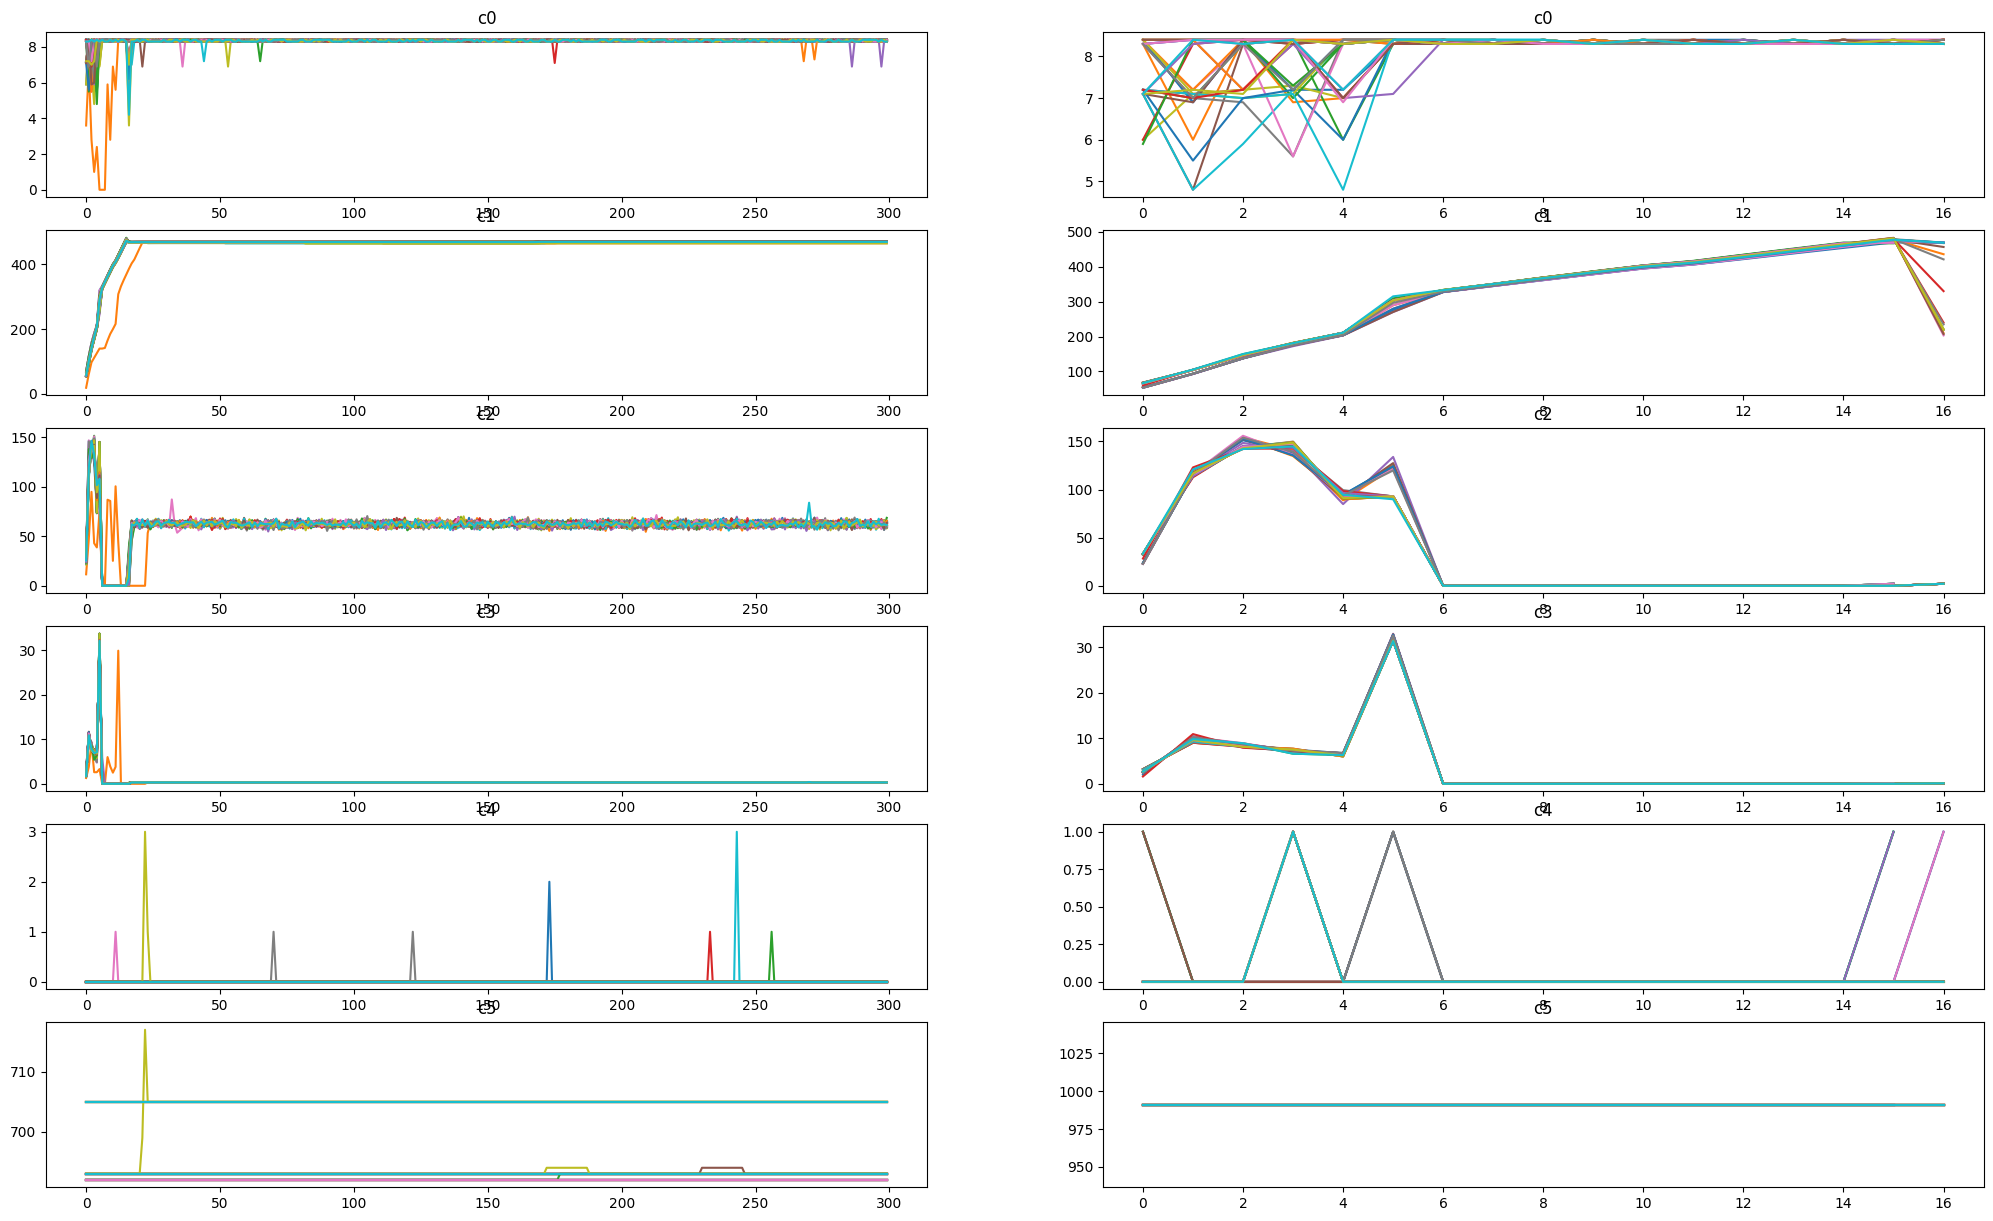

In [255]:

def detect_anomaly(experiment,output,workload,defect):
    path              = os.path.join(output,workload,defect)
    fig, axs = None,None
    for filename in os.listdir(path):
        if not filename.endswith("csv"): continue
        df = pd.read_csv(os.path.join(path,filename),sep=";",header=None)
        df.columns = map(lambda x:f"c{x}",df.columns)
        if fig is None:
            fig, axs = plt.subplots(len(df.columns),2,figsize=(25,15))
        for i,col in enumerate(df.columns):
            axs[i][1 if defect in filename else 0].plot(df[col])
            axs[i][1 if defect in filename else 0].set_title(col)
    plt.show()
    return df

#run_experiment(experiment,output,"SQuADv1","MODEL")
df = detect_anomaly(experiment,output,"SQuADv1","MEMORY")


# Distances Measure

In [37]:
from subprocess import Popen, PIPE, call
import tempfile

def gzip_compression(fname, slowness = 6, **kwargs):
    process = Popen(['gzip', '-c', '-%d' % slowness, fname], stdout=PIPE)
    output  = process.communicate()[0]
    #print(output)
    compressed_size = len(output)
    return compressed_size

def compression_fn(path):
    return gzip_compression(path)
    
def ncd_distance(path,file1,file2):
    compressed_sizes = (compression_fn(os.path.join(path,file1)),compression_fn(os.path.join(path,file2)))
    fd, temp_path = tempfile.mkstemp()
    try:
        with os.fdopen(fd, 'wb') as tmp,open(os.path.join(path,file1),"rb") as f1,open(os.path.join(path,file2),"rb") as f2:
            tmp.write(f1.read())
            tmp.write(f2.read())
        paired_compressed_size = compression_fn(temp_path)
    finally:
        os.remove(temp_path)
    minimum, maximum = sorted(compressed_sizes)
    ncd = float(paired_compressed_size - minimum)/maximum
    return ncd

def preprocess(experiment,output,workload,defect):
    path              = os.path.join(output,workload,defect)
    
    files_def = [filename for filename in os.listdir(path) if defect in filename]
    files_ref = [filename for filename in os.listdir(path) if defect not in filename]
    
    files_def = sorted(files_def,key=lambda file:int(file.split("_")[-2]))
    files_ref = sorted(files_ref,key=lambda file:int(file.split("_")[-2]))
    
    distances_def         = [] 
    for pair in itertools.combinations(files_def,2):
        distances_def.append(ncd_distance(path,pair[0],pair[1]))
    
    distances_ref         = [] 
    for pair in itertools.combinations(files_ref,2):
        distances_ref.append(ncd_distance(path,pair[0],pair[1]))
    
    distances_comb         = []
    for pair in itertools.product(files_def,files_ref):
        distances_comb.append(ncd_distance(path,pair[0],pair[1]))
    
    return [distances_def,distances_ref,distances_comb]

In [36]:

path = os.getcwd()
with open("file1","w") as f1,open("file2","w") as f2:
    for i in range(300):
        f1.write(str(i)+"\n")
        f2.write(str(299-i)+"\n")

print(ncd_distance(path,"file1","file2"))
            

0.9574074074074074


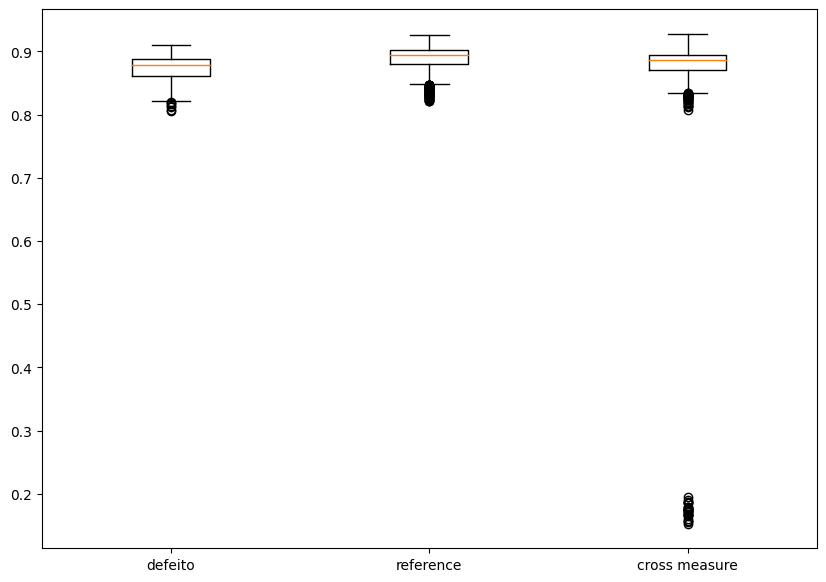

In [43]:
defect = "CONTROL"
workload = "SQuADv1"
data = preprocess(experiment,output,workload,defect)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
plt.xticks([1, 2, 3],['defeito', 'reference', 'cross measure'])
 
# show plot
plt.show()

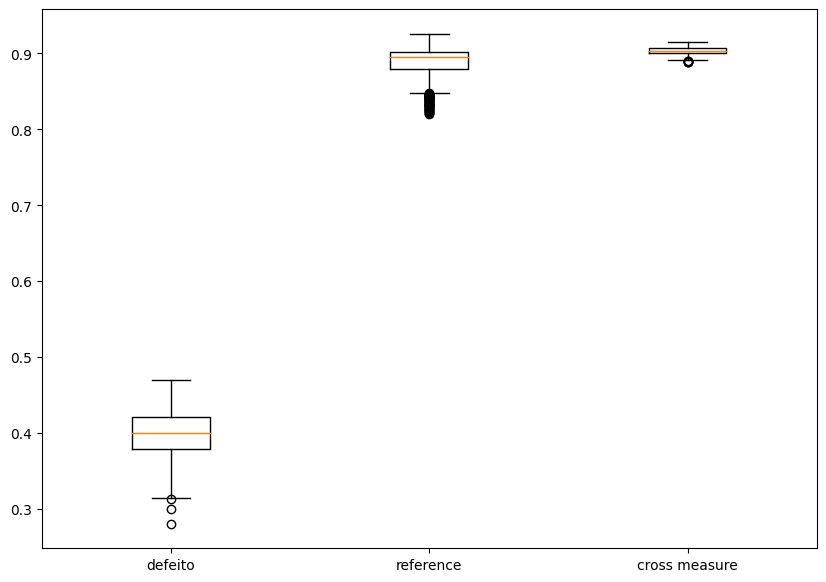

In [44]:
defect = "MEMORY"
workload = "SQuADv1"
data = preprocess(experiment,output,workload,defect)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
plt.xticks([1, 2, 3],['defeito', 'reference', 'cross measure'])
 
# show plot
plt.show()

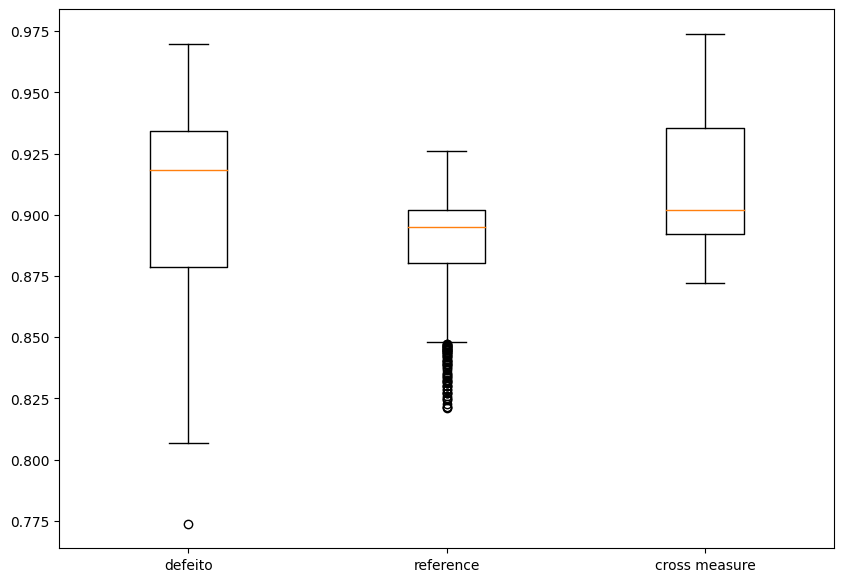

In [42]:
defect = "MODEL"
workload = "SQuADv1"
data = preprocess(experiment,output,workload,defect)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
plt.xticks([1, 2, 3],['defeito', 'reference', 'cross measure'])
 
# show plot
plt.show()

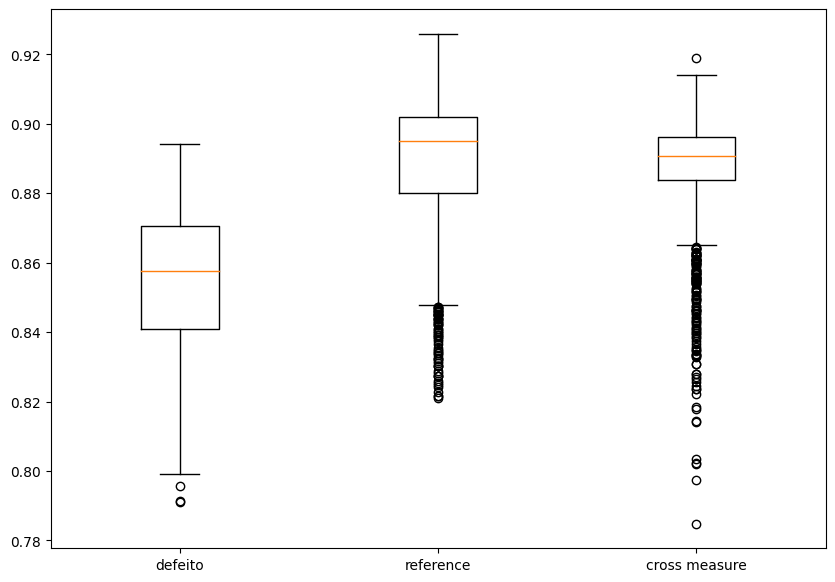

In [45]:
defect = "TRAIN"
workload = "SQuADv1"
data = preprocess(experiment,output,workload,defect)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
plt.xticks([1, 2, 3],['defeito', 'reference', 'cross measure'])
 
# show plot
plt.show()